# Task 1

In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Gamma_np_dict={
    "Gamma_shape=2._scale=1.":np.random.gamma(2.,size=10000),
    "Gamma_shape=4._scale=1.":np.random.gamma(4.,size=10000),
    "Gamma_shape=2._scale=2.":np.random.gamma(2.,2.,size=10000),
    "Gamma_shape=4._scale=2.":np.random.gamma(4.,2.,size=10000)
}

In [10]:
Dataframe=pd.DataFrame.from_dict(Gamma_np_dict)

In [11]:
Gamma_np_MeltedData=Dataframe.melt()

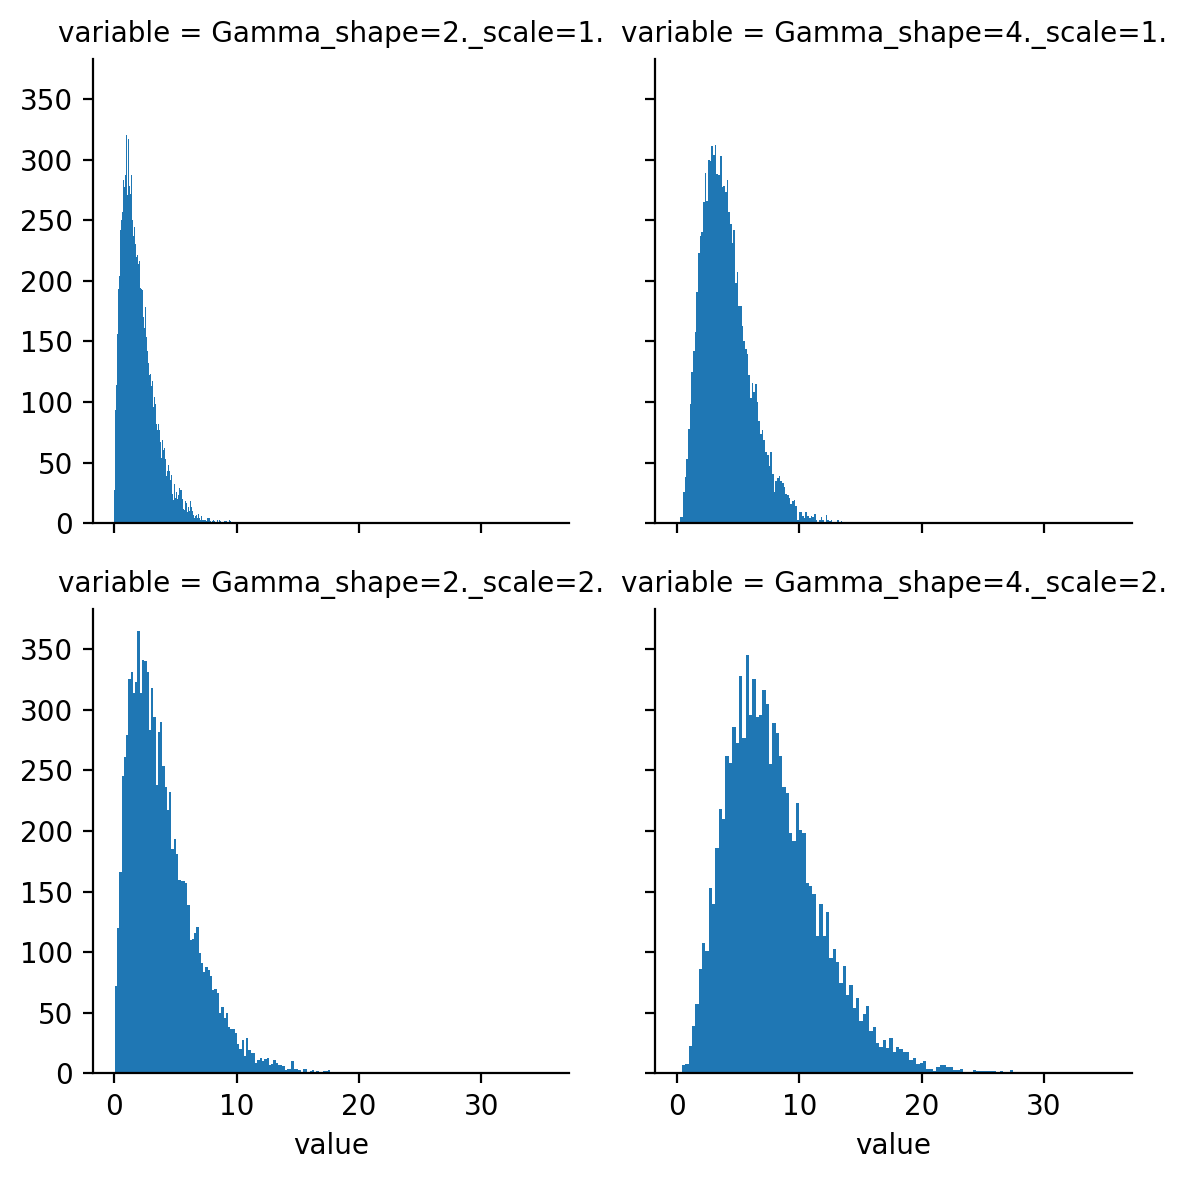

In [12]:
Graph=sns.FacetGrid(Gamma_np_MeltedData, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist,"value",cumulative=False,bins=128)

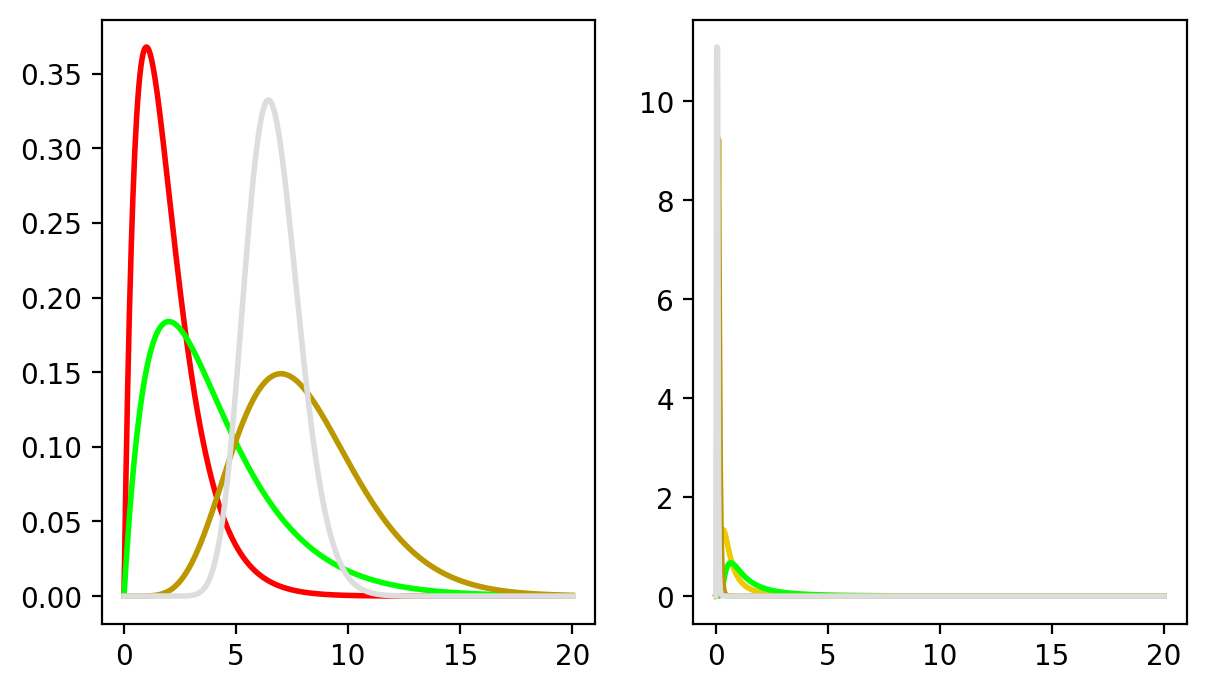

In [13]:
import pystan
import stan_utility

import scipy.stats as stats
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
blue="#0000FF"
red="#FF0000"
light_grey="#DDDDDD"

colors=[light, light_highlight, mid, mid_highlight,
        dark, dark_highlight, green, blue, red, light_grey]

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

fig, axes = plt.subplots(1, 2, figsize=(7, 4))
x2=np.linspace(0,20,500)
alpha=2.
beta=1.
axes[0].plot(x2,stats.gamma.pdf(x2,a=alpha,scale=1/beta),color=red,linewidth=2)
alpha=2.
beta=1/2.
axes[0].plot(x2,stats.gamma.pdf(x2,a=alpha,scale=1/beta),color=green,linewidth=2)
alpha=8.
beta=1.
axes[0].plot(x2,stats.gamma.pdf(x2,a=alpha,scale=1/beta),color=dark_highlight,linewidth=2)
alpha=30.
beta=4.5
axes[0].plot(x2,stats.gamma.pdf(x2,a=alpha,scale=1/beta),color=light_grey,linewidth=2)

alpha=2.
beta=1.
axes[1].plot(x2,stats.invgamma.pdf(x2,a=alpha,scale=1/beta),color=dark,linewidth=2)
alpha=2.
beta=1/2.
axes[1].plot(x2,stats.invgamma.pdf(x2,a=alpha,scale=1/beta),color=green,linewidth=2)
alpha=8.
beta=1.
axes[1].plot(x2,stats.invgamma.pdf(x2,a=alpha,scale=1/beta),color=dark_highlight,linewidth=2)
alpha=8.
beta=2.
axes[1].plot(x2,stats.invgamma.pdf(x2,a=alpha,scale=1/beta),color=light_grey,linewidth=2)

plt.show()

In [14]:
with open('prior_tune.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y,       //unknowns
                    vector theta,   //parameters
                    real[] x_r,     // data(real)
                    int[] x_i) {    //data(integer)
    vector[2] deltas;
    // At the end we will receive distribution from 5 to 10 with 98% probability
    deltas[1] = gamma_cdf(theta[1], y[1], y[2]) - 0.99;
    deltas[2] = gamma_cdf(theta[2], y[1], y[2]) - 0.01;
    return deltas;
  }
}

data {
  vector<lower=0>[2] y_guess; // Initial guess of Gaussian standard deviation
  vector<lower=0>[2] theta;   // Target quantile
}

transformed data {
  vector[2] y;
  real x_r[0];
  int x_i[0];

  // Find gamma parameters that ensures 98% probabilty from 5 to 10
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);

  print("Alpha  = ", y[1]);
  print("Beta = ", y[2]);
}

generated quantities {
  real alpha = y[1];
  real beta = y[2];
}


In [70]:
model_prior=stan_utility.compile_model('prior_tune.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_85fceaccbbeca6959b8fb5264d8c185b NOW.


In [71]:
data=dict(y_guess=np.array([1,0.1]),theta=np.array([10,5]))
sim_nm = model_prior.sampling(data=data,
                            seed=1052020,
                            algorithm="Fixed_param",
                            iter=1, 
                            warmup=0,
                            chains=1)

In [73]:
alpha = np.round(sim_nm.extract()['alpha'][0])
beta = np.round(sim_nm.extract()['beta'][0])
print('Alpha: {a}, Beta: {b}'.format(a=alpha, b=beta))

Alpha: 46.0, Beta: 6.0


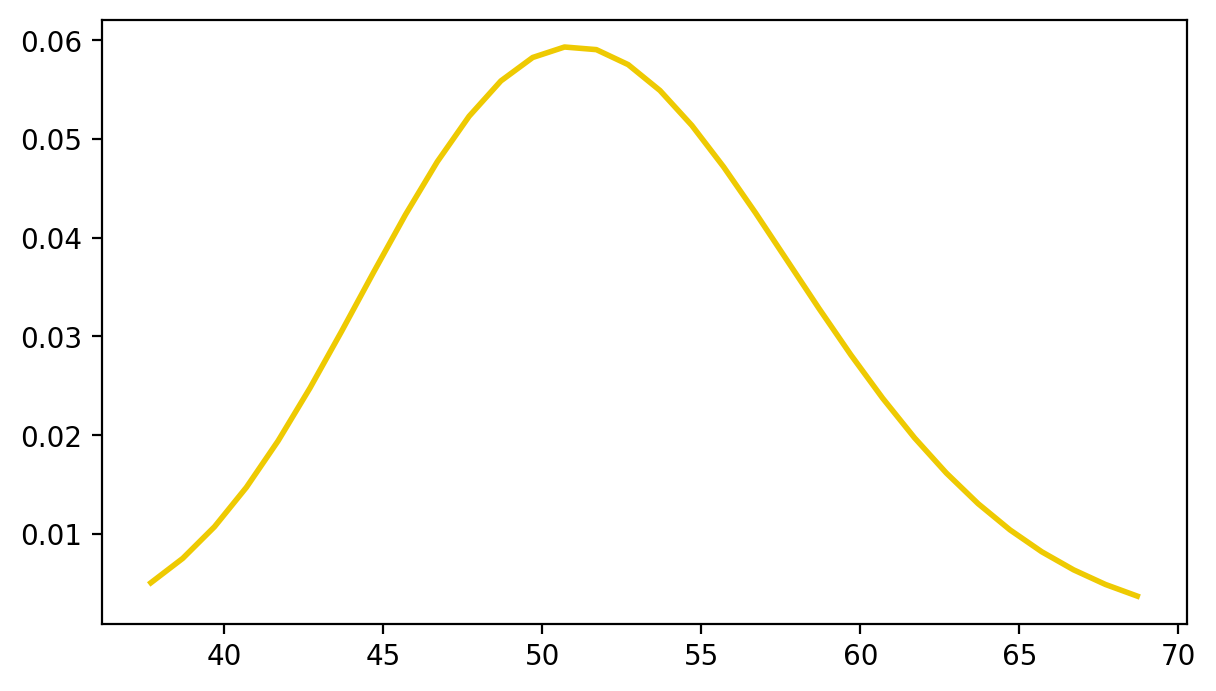

In [74]:
# Something goes wrong with section of distribution not sure why
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
x = np.arange(stats.gamma.ppf(0.01, alpha, beta),
              stats.gamma.ppf(0.99, alpha, beta))
axes.plot(x,stats.gamma.pdf(x,alpha,beta),color=dark,linewidth=2)


# Task 2
## Negative binomial distribution

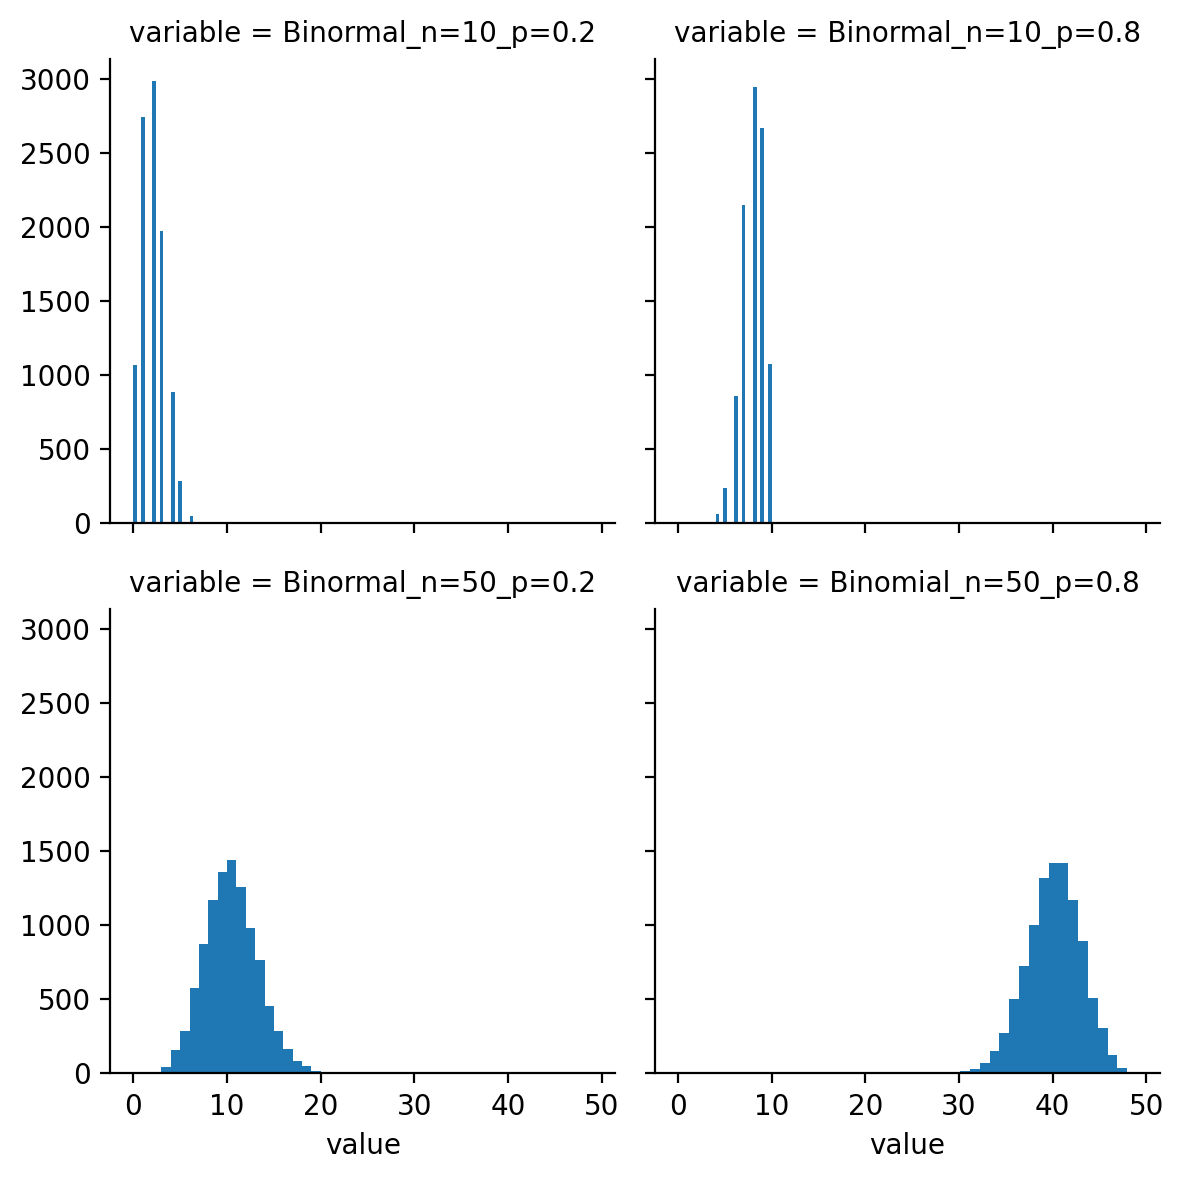

In [17]:
size = 10000
binormal_dict = {
    "Binormal_n=10_p=0.2": np.random.binomial(10, 0.2, size),
    "Binormal_n=10_p=0.8": np.random.binomial(10, 0.8, size),
    "Binormal_n=50_p=0.2": np.random.binomial(50, 0.2, size),
    "Binomial_n=50_p=0.8": np.random.binomial(50, 0.8, size)
}

binormal_df = pd.DataFrame.from_dict(binormal_dict)
melted_binormal = binormal_df.melt()

Graph = sns.FacetGrid(melted_binormal, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist, "value", cumulative=False, bins=20)

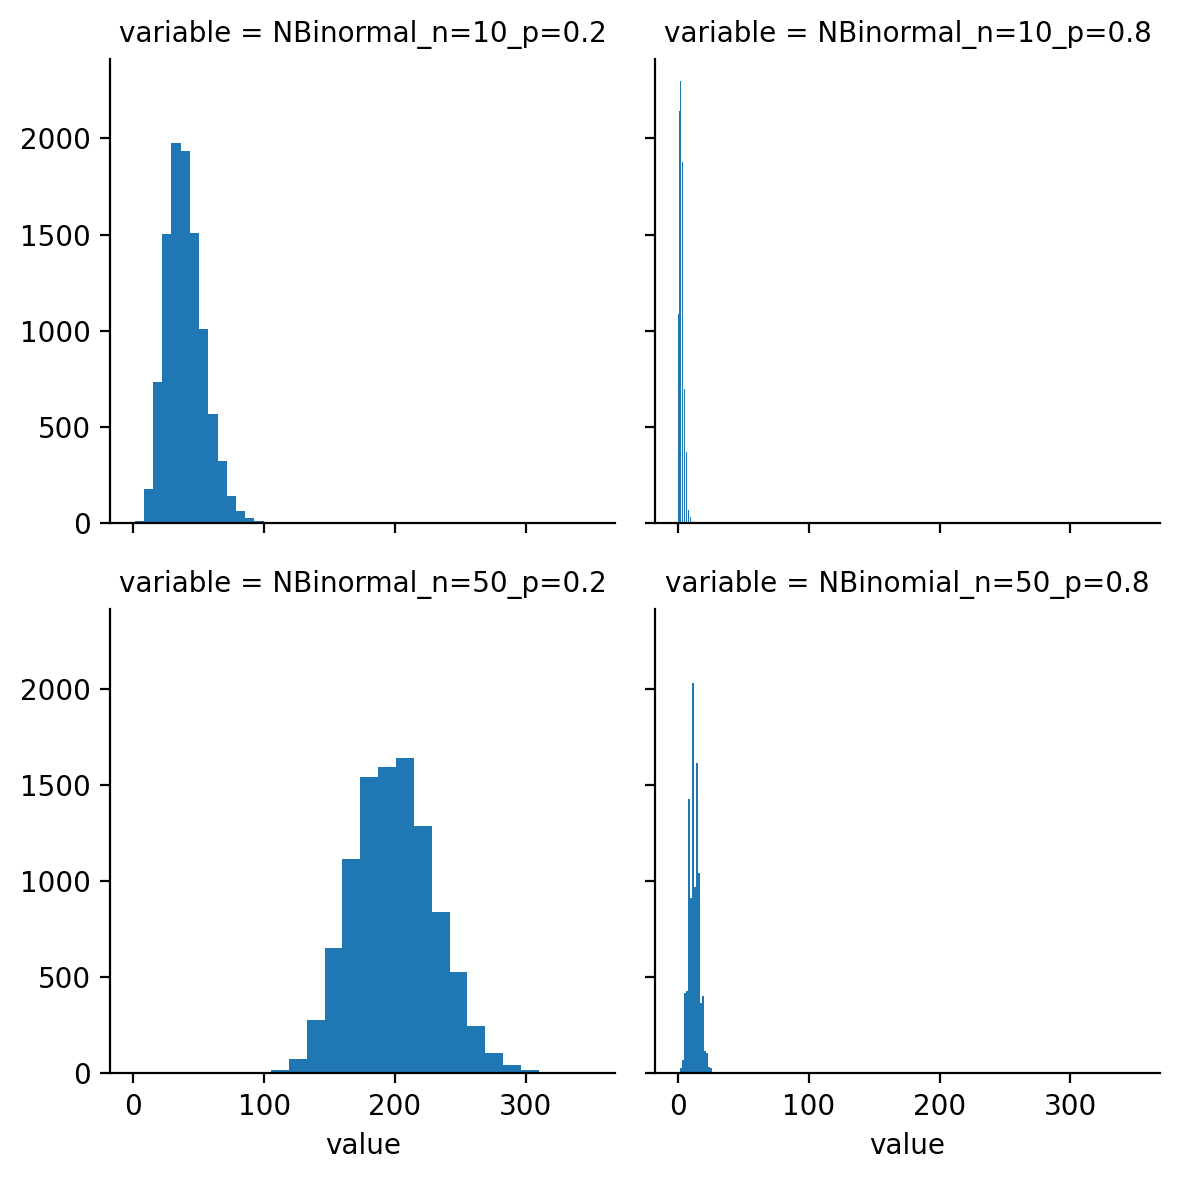

In [18]:
Nbinormal_dict = {
    "NBinormal_n=10_p=0.2": np.random.negative_binomial(10, 0.2, size),
    "NBinormal_n=10_p=0.8": np.random.negative_binomial(10, 0.8, size),
    "NBinormal_n=50_p=0.2": np.random.negative_binomial(50, 0.2, size),
    "NBinomial_n=50_p=0.8": np.random.negative_binomial(50, 0.8, size)
}

Nbinormal_df = pd.DataFrame.from_dict(Nbinormal_dict)
melted_Nbinormal = Nbinormal_df.melt()

Graph = sns.FacetGrid(melted_Nbinormal, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist, "value", cumulative=False, bins=20)

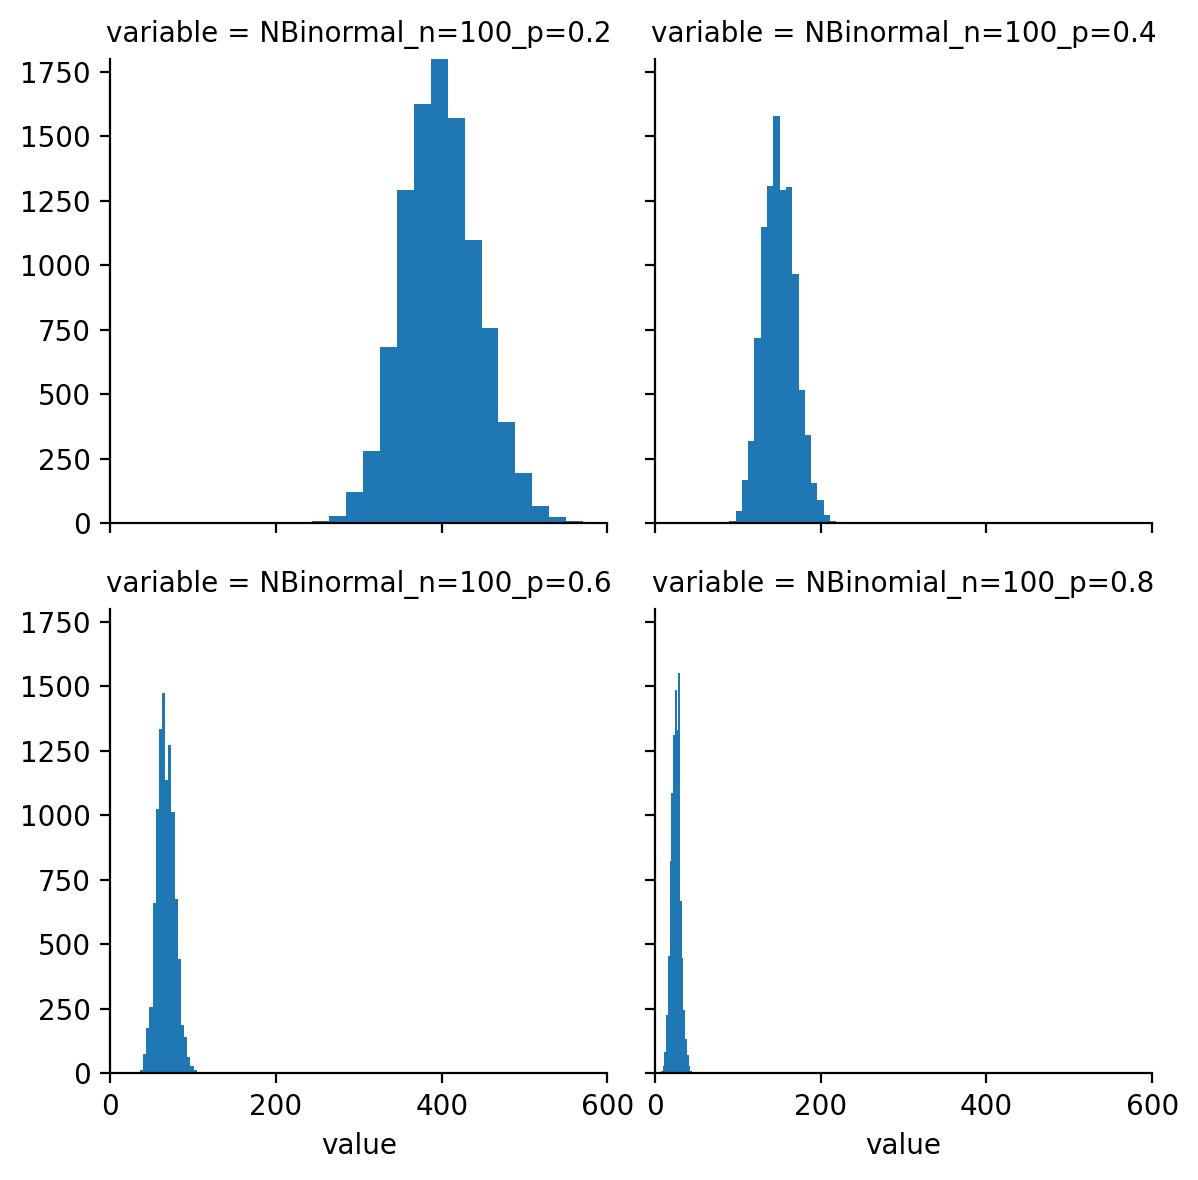

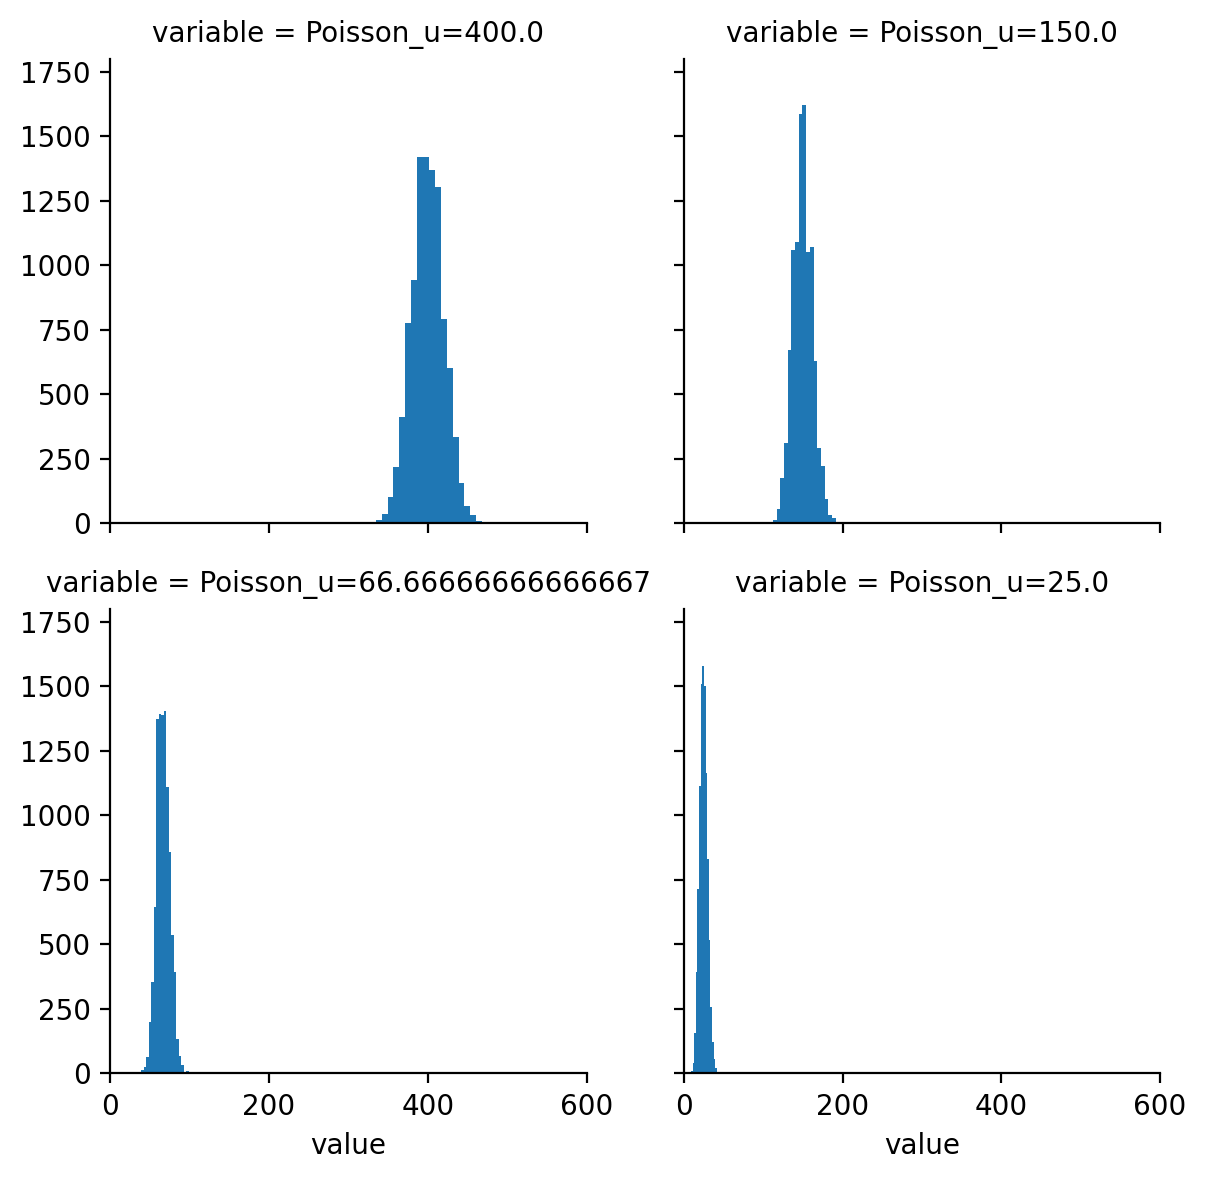

In [19]:
p=[0.2,0.4,0.6,0.8]
n=100
u=[stats.nbinom.mean(n, x) for x in p]

Nbinormal_dict_comp = {
    "NBinormal_n=100_p={}".format(p[0]): np.random.negative_binomial(n, p[0], size),
    "NBinormal_n=100_p={}".format(p[1]): np.random.negative_binomial(n, p[1], size),
    "NBinormal_n=100_p={}".format(p[2]): np.random.negative_binomial(n, p[2], size),
    "NBinomial_n=100_p={}".format(p[3]): np.random.negative_binomial(n, p[3], size)
}

Poisson_dict_comp = {
    "Poisson_u={}".format(u[0]): np.random.poisson(u[0], size=size),
    "Poisson_u={}".format(u[1]): np.random.poisson(u[1], size=size),
    "Poisson_u={}".format(u[2]): np.random.poisson(u[2], size=size),
    "Poisson_u={}".format(u[3]): np.random.poisson(u[3], size=size)
}


Nbinormal_df_comp = pd.DataFrame.from_dict(Nbinormal_dict_comp)
melted_Nbinormal_comp = Nbinormal_df_comp.melt()

Graph = sns.FacetGrid(melted_Nbinormal_comp, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist, "value", cumulative=False, bins=20)
Graph.set(xlim=(0, 600), ylim=(0, 1800))

Poisson_df_comp = pd.DataFrame.from_dict(Poisson_dict_comp)
melted_Poisson_comp = Poisson_df_comp.melt()

Graph = sns.FacetGrid(melted_Poisson_comp, col="variable", sharex=True, col_wrap=2)
Graph.map(plt.hist, "value", cumulative=False, bins=20)
Graph.set(xlim=(0, 600), ylim=(0, 1800))

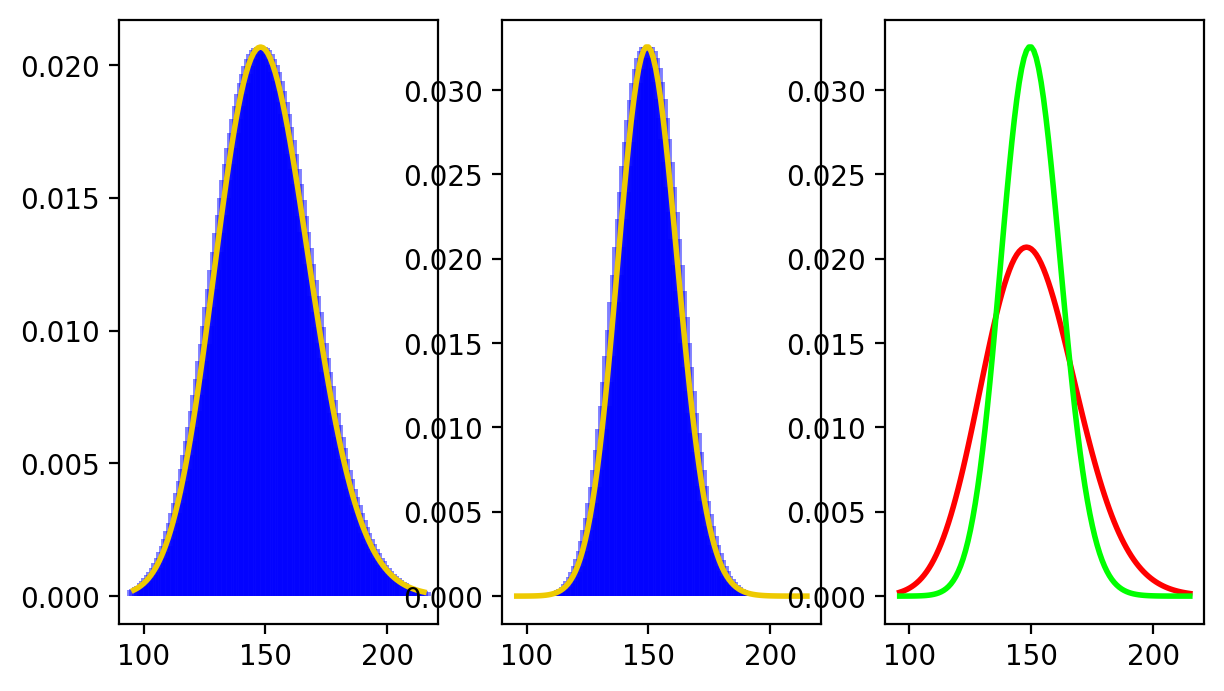

In [20]:

fig, axes = plt.subplots(1, 3, figsize=(7, 4))
x = np.arange(stats.nbinom.ppf(0.001, n, p[1]),
              stats.nbinom.ppf(0.999, n, p[1]))
axes[0].plot(x,stats.nbinom.pmf(x,n,p[1]),color=dark,linewidth=2)
axes[0].vlines(x, 0, stats.nbinom.pmf(x, n, p[1]), colors='b', lw=5, alpha=0.5)
axes[1].plot(x,stats.poisson.pmf(x, u[1]),color=dark,linewidth=2)
axes[1].vlines(x, 0, stats.poisson.pmf(x, u[1]), colors='b', lw=5, alpha=0.5)
axes[2].plot(x,stats.nbinom.pmf(x,n,p[1]),color=red,linewidth=2)
axes[2].plot(x,stats.poisson.pmf(x, u[1]),color=green,linewidth=2)
plt.show()


# Task 3
## Student-t family distributions
Student-t distributions can be considered generalizations of Gaussian distributions with varying scale.
Use both degrees of freedom and dispersion parametrizations to see how changing parameters moves from normal distribution.
Take a special case of degrees of freedom equal to 1, as this is Cauchy distribution.
See how mean and variance behave while you increase number of samples.

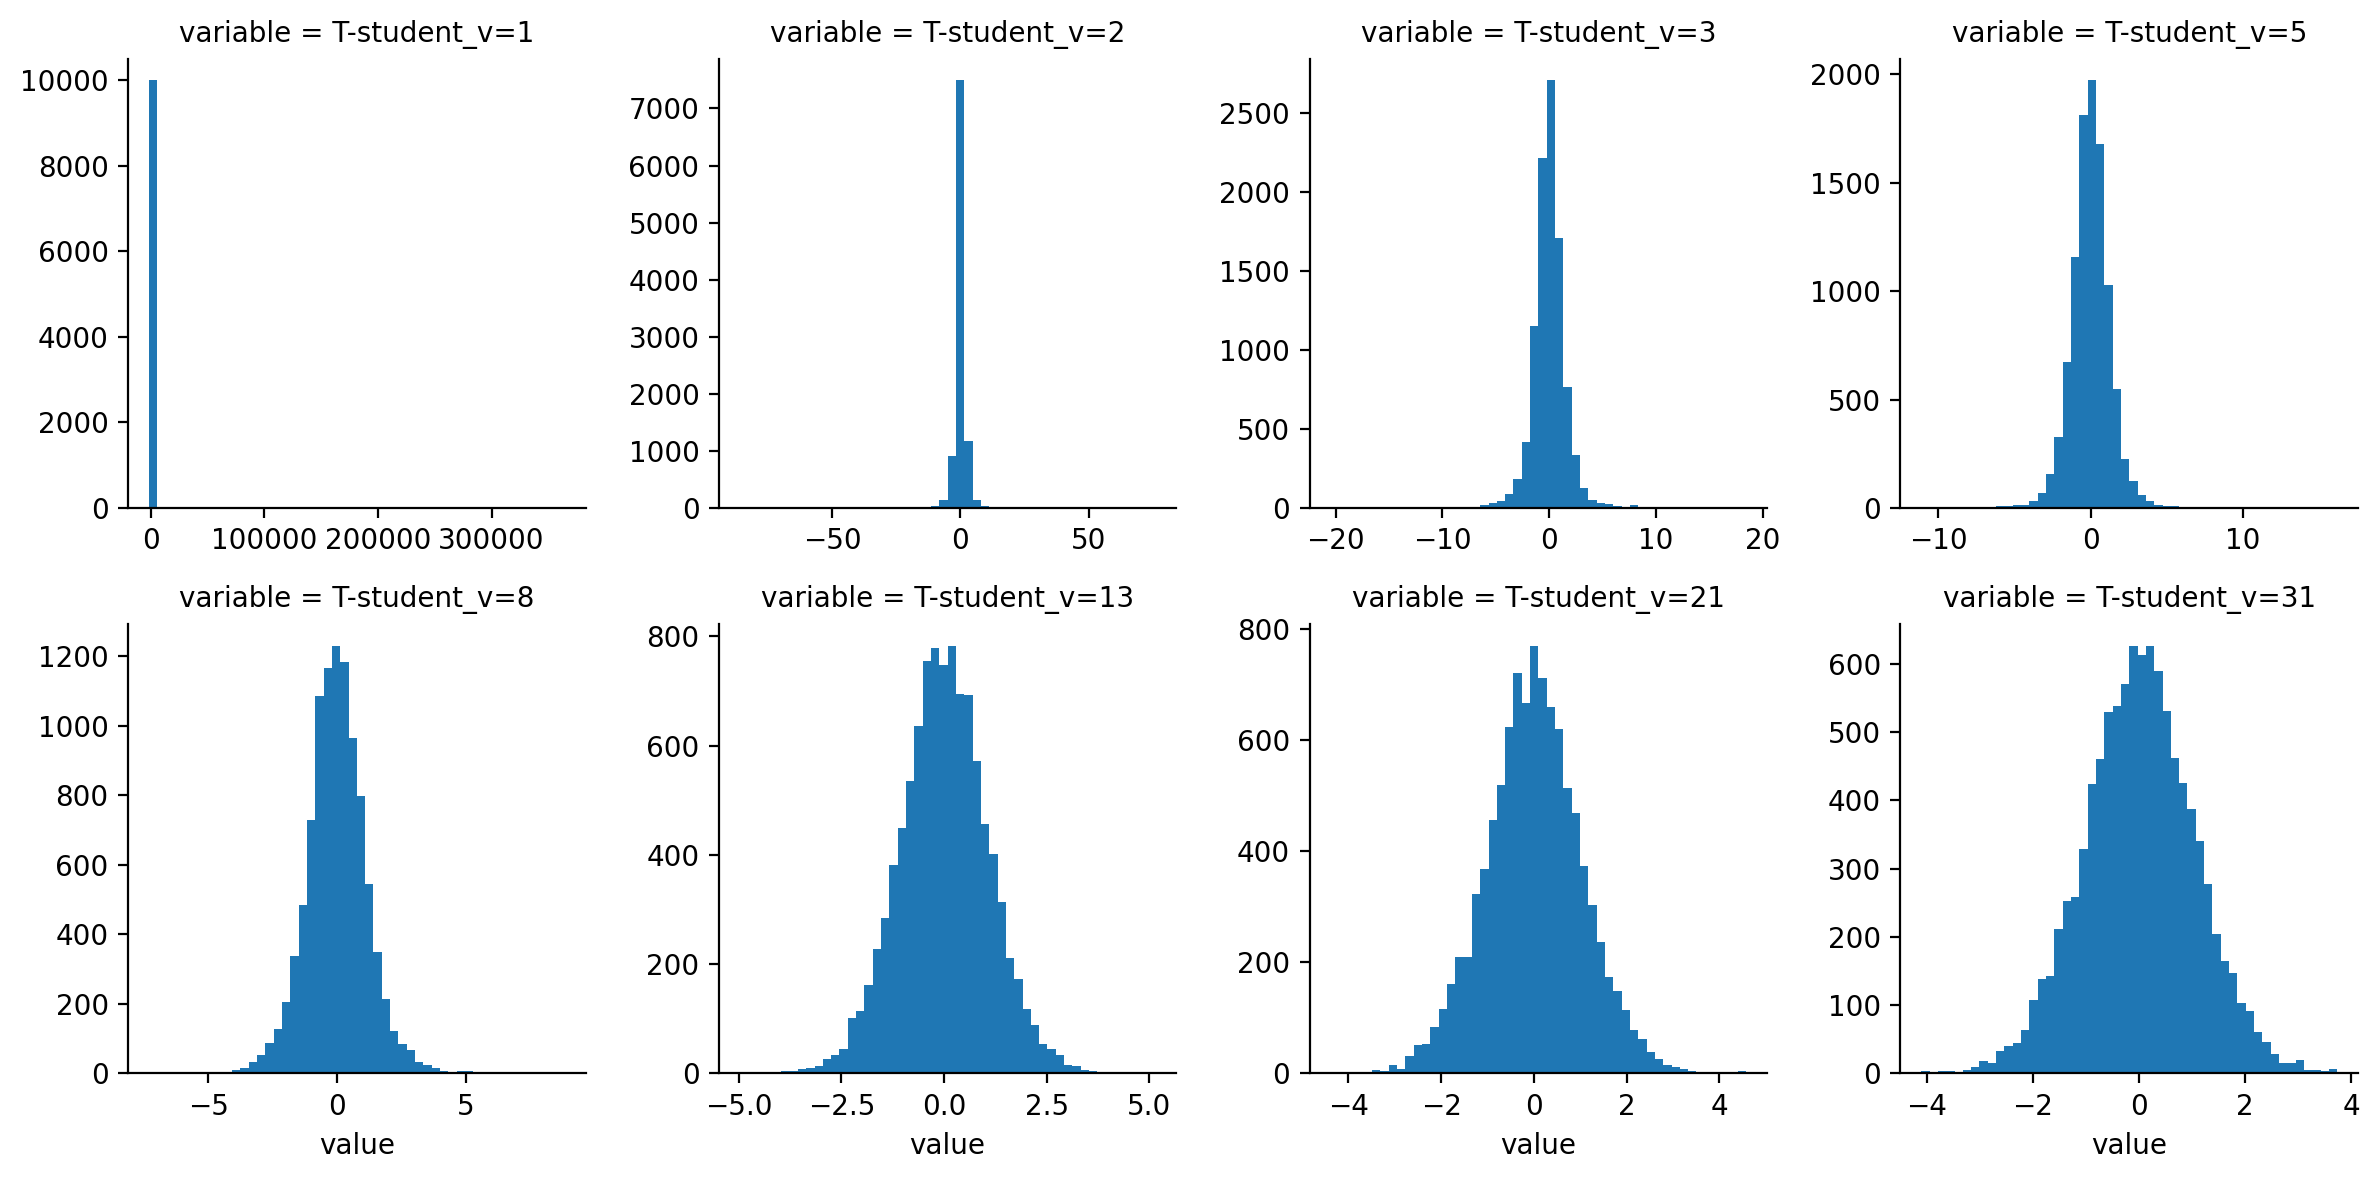

In [21]:
size = 10000
n=[1,2,3,5,8,13,21,31]
student_dict: dict = {}

for param in n:
    student_dict['T-student_v={}'.format(param)] = np.random.standard_t(param, size)


tstudent_df = pd.DataFrame.from_dict(student_dict)
melted_tstudent = tstudent_df.melt()

Graph = sns.FacetGrid(melted_tstudent, col="variable", sharey=False, sharex=False, col_wrap=4)
Graph = Graph.map(plt.hist, "value", cumulative=False, bins=50)

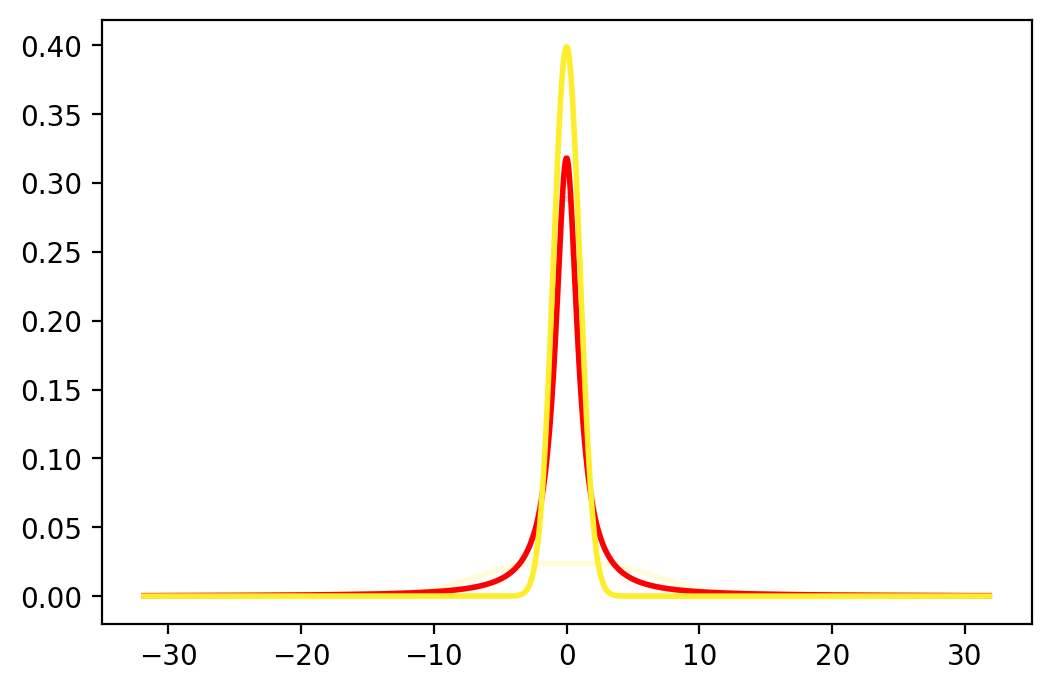

In [22]:
# Cauchy distribution
samples = [10, 100, 1000]
fig, ax = plt.subplots(1, 1)
for i in range(len(samples)):
    xc = np.linspace(stats.t.ppf(0.01, n[0]),
                    stats.t.ppf(0.99, n[0]),samples[i])
    ax.plot(xc, stats.t.pdf(xc, n[0]),color=colors[-i],linewidth=2)

ax.plot(xc, stats.norm.pdf(xc),color=colors[2],linewidth=2)
plt.show()


In [23]:
m = stan_utility.compile_model('student_t.stan')

Using cached StanModel


For iter: 10
 Summary: Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=10; warmup=5; thin=1; 
post-warmup draws per chain=5, total post-warmup draws=5.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y     -3.85    0.25    0.7  -4.64  -4.53   -3.6  -3.36  -2.99      8   2.91
lp__  -2.74    0.11   0.34  -3.11  -3.07  -2.64   -2.5  -2.29      9   2.59

Samples were drawn using NUTS at Thu Jun  4 19:26:22 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
For iter: 100
 Summary: Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=50.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y     -1.72    1.71   8.06  -27.3  -2.01  -0.22   1.23   18.3     

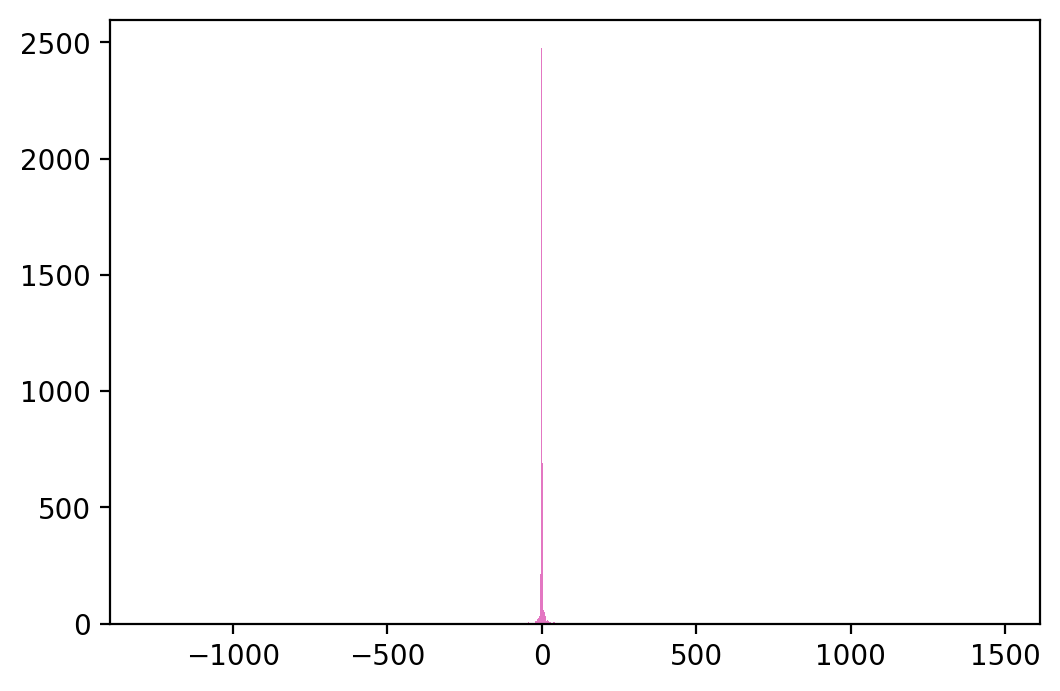

In [33]:
iterations = [10,100,500,1000,5000,10000]
for iter in iterations:
    model=m.sampling(data={'nu': 1.,
                           'mu': 0.,
                           'sigma': 1.},
                     iter=iter,
                     chains=1,
                     seed=42342)
    dist = model.extract()
    THist = plt.hist(dist['y'], bins=iter)
    print('For iter: {iter}\n Summary: {stansum}'.format(iter=iter,
                                                         stansum=model.stansummary()))
    
THist = plt.hist(dist['y'], bins=1000)

Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
y      0.74     0.8   7.01 -19.77  -0.57   0.26   1.21   23.32     76    1.0
lp__  -1.36    0.33   1.74  -6.54  -1.89  -0.63  -0.15 -9.6e-3     27   1.05

Samples were drawn using NUTS at Thu Jun  4 19:33:18 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


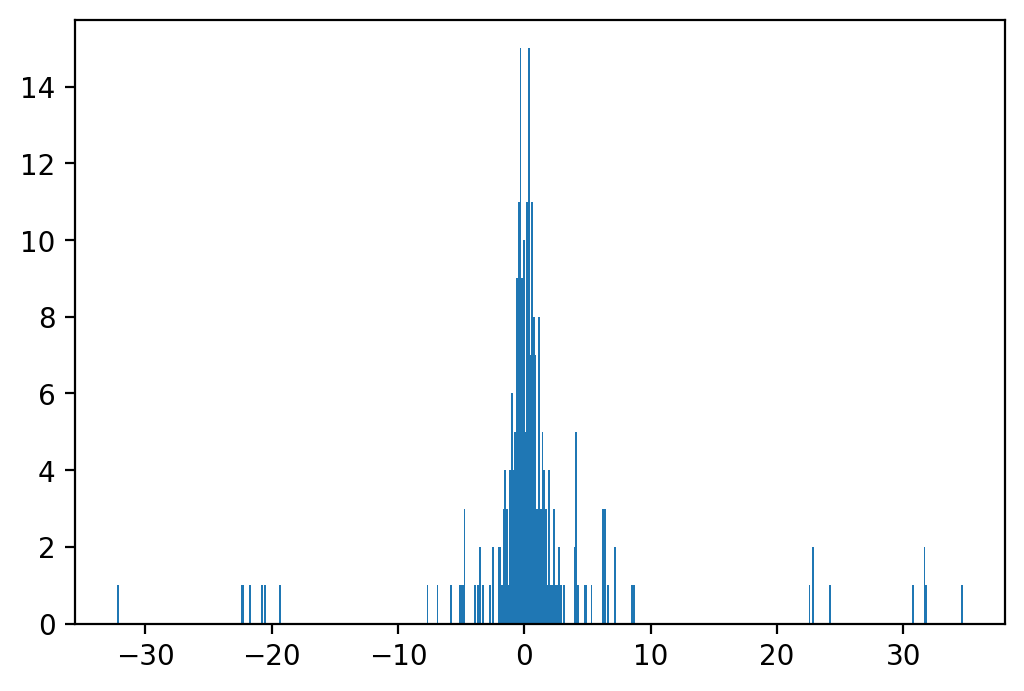

In [46]:
model=m.sampling(data={'nu': 1.,
                       'mu': 0.,
                       'sigma': 1.},
                     iter=500,
                     chains=1,
                     seed=42342)
dist = model.extract()
THist = plt.hist(dist['y'], bins=500)
print(model.stansummary())

Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
y      1.05    0.53   3.55  -7.72  -0.19   1.09   2.27    8.58     44   1.01
lp__  -1.41    0.32    1.4   -4.5  -2.43  -0.94   -0.2 -3.2e-3     19   1.05

Samples were drawn using NUTS at Thu Jun  4 19:33:22 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


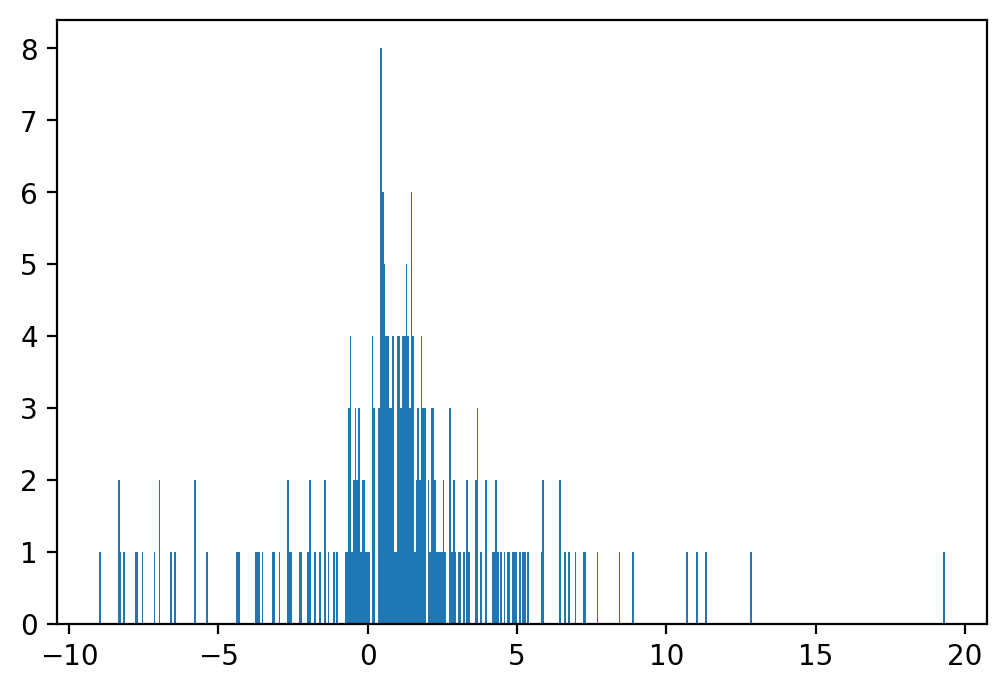

In [47]:
model=m.sampling(data={'nu': 1.,
                       'mu': 1.,
                       'sigma': 1.},
                     iter=500,
                     chains=1,
                     seed=42342)
dist = model.extract()
THist = plt.hist(dist['y'], bins=500)
print(model.stansummary())

Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
y     -1.04     0.2   1.61  -3.97  -1.95  -0.85  -0.15    1.84     68   1.01
lp__  -0.84     0.1    0.8  -2.75  -1.38  -0.58  -0.16 -9.9e-4     64    1.0

Samples were drawn using NUTS at Thu Jun  4 19:33:25 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


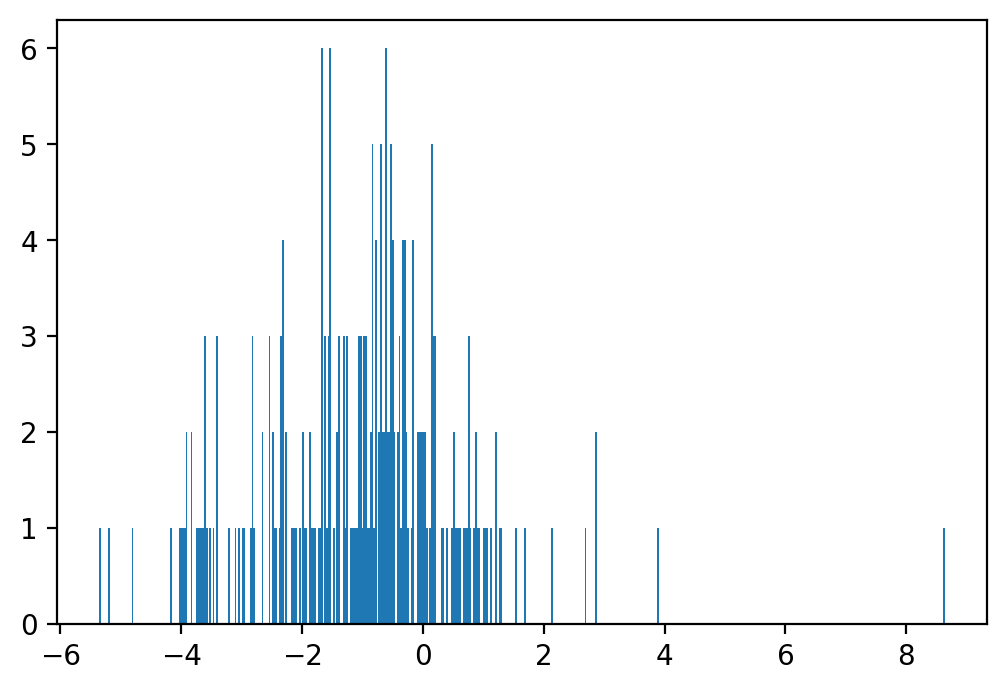

In [48]:
model=m.sampling(data={'nu': 1.,
                       'mu': -1.,
                       'sigma': 1.},
                     iter=500,
                     chains=1,
                     seed=42342)
dist = model.extract()
THist = plt.hist(dist['y'], bins=500)
print(model.stansummary())

Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
y     -0.04    0.09   0.92  -1.85  -0.62  -0.05   0.57    1.79    118   1.02
lp__  -0.42    0.05   0.52  -2.03  -0.61  -0.21  -0.05 -1.3e-4     94    1.0

Samples were drawn using NUTS at Thu Jun  4 19:34:14 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


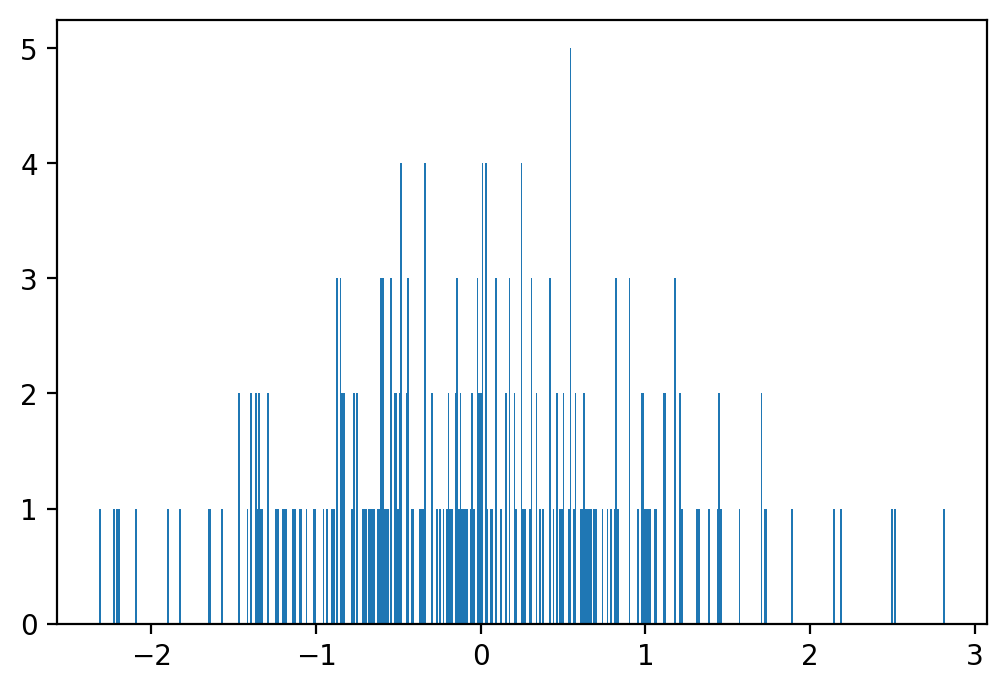

In [51]:
model=m.sampling(data={'nu': 5.,
                       'mu': 0.,
                       'sigma': 1.},
                     iter=500,
                     chains=1,
                     seed=42342)
dist = model.extract()
THist = plt.hist(dist['y'], bins=500)
print(model.stansummary())

Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
y     -0.25    1.07  10.71 -29.37  -3.98   -0.7   4.45   23.57    100   1.02
lp__   -0.9    0.12   1.04  -3.85   -1.3  -0.53  -0.11 -9.2e-4     73   1.03

Samples were drawn using NUTS at Thu Jun  4 19:34:16 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


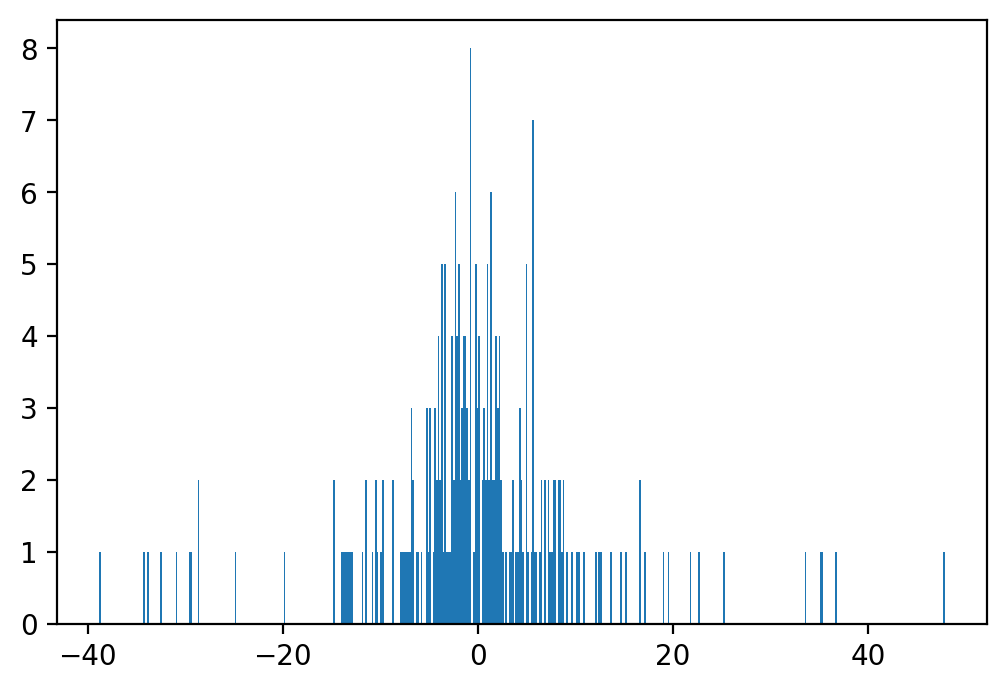

In [52]:
model=m.sampling(data={'nu': 1.,
                       'mu': 0.,
                       'sigma': 5.},
                     iter=500,
                     chains=1,
                     seed=42342)
dist = model.extract()
THist = plt.hist(dist['y'], bins=500)
print(model.stansummary())



Inference for Stan model: anon_model_762a3b225d914001421f89622b2fadb9.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
y     -0.39     0.5   5.45 -11.08  -3.36  -0.73   2.79   12.67    117    1.0
lp__  -0.52    0.08   0.76   -2.9  -0.69  -0.22  -0.05 -4.6e-4     88   1.01

Samples were drawn using NUTS at Thu Jun  4 19:34:24 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


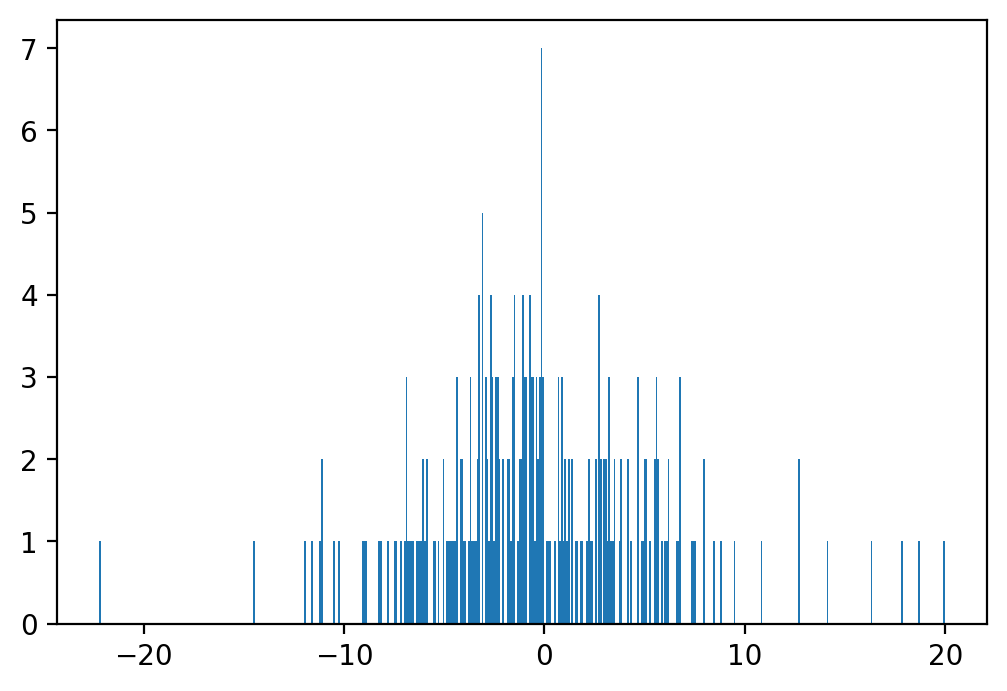

In [53]:
model=m.sampling(data={'nu': 5.,
                       'mu': 0.,
                       'sigma': 5.},
                     iter=500,
                     chains=1,
                     seed=42342)
dist = model.extract()
THist = plt.hist(dist['y'], bins=500)
print(model.stansummary())

# Task 4
## Multivariate normal distributions

Multivariate normal distributions Consider density plots and 2d histograms for visualisation of behavior of 2 dimensional Multivariate normal. Use the correlation matrix decompositon of covariance matrix to see how individual variances and correlations infulence the distribution. For 3 and 4 dimensional normal distributions observe the marginals of variables with histograms.


In [54]:
Multi_normal_model = stan_utility.compile_model('Multi_normal.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2c0527d257029df57827adc7864cba99 NOW.


In [62]:
Multi_normal_Sampled=Multi_normal_model.sampling(data={'mu': np.array([0.,0.]),
                                                       'Sigma': np.matrix('1 1; 1 1')},
                                                iter=1000)
Multi_normal_dist = Multi_normal_Sampled.extract()
print(Multi_normal_dist)
MultiNormHist = plt.hist2d(Multi_normal_dist['y[0]'],Multi_normal_dist['y[1]'], bins=500)
print(Multi_normal_Sampled.stansummary())


RuntimeError: Initialization failed.